# dcm to image

참고: https://github.com/ucs198604/dicom2jpg

In [9]:
import os
import cv2
import json
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from pydicom.pixel_data_handlers.util import apply_voi_lut, apply_modality_lut


In [10]:
# from ./dcm2img.py
def dcm2img(dcm_path):
    ds = pydicom.dcmread(dcm_path)
    pixel_array = ds.pixel_array.astype(float)

    if 'RescaleSlope' in ds and 'RescaleIntercept' in ds:
        rescale_slope = float(ds.RescaleSlope) 
        rescale_intercept = float(ds.RescaleIntercept)
        pixel_array = (pixel_array) * rescale_slope + rescale_intercept
    else:
        pixel_array = apply_modality_lut(pixel_array, ds)

    if 'VOILUTFunction' in ds and ds.VOILUTFunction=='SIGMOID':
        pixel_array = apply_voi_lut(pixel_array, ds)
    elif 'WindowCenter' in ds and 'WindowWidth' in ds:
        window_center = ds.WindowCenter
        window_width = ds.WindowWidth
        if type(window_center)==pydicom.multival.MultiValue:
            window_center = float(window_center[0])
        else:
            window_center = float(window_center)
        if type(window_width)==pydicom.multival.MultiValue:
            window_width = float(window_width[0])
        else:
            window_width = float(window_width)
        pixel_array = np.piecewise(
            pixel_array, [pixel_array<=(window_center-(window_width)/2), pixel_array>(window_center+(window_width)/2)], 
            [pixel_array.min(), pixel_array.max(), lambda data: ((data-window_center+window_width/2)/window_width*(pixel_array.max() - pixel_array.min()))+pixel_array.min()])
    else:
        pixel_array = apply_voi_lut(pixel_array, ds)

    # normalize to 8 bit
    pixel_array = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min())) * 255.0

    if 'PhotometricInterpretation' in ds and ds.PhotometricInterpretation == "MONOCHROME1":
        pixel_array = np.max(pixel_array) - pixel_array

    image = pixel_array.astype('uint8')

    return image

In [17]:
def getTag(dcm_path):
    tag = {}
    ds = pydicom.dcmread(dcm_path)

    RescaleSlope = ds.get('RescaleSlope', 'None')
    RescaleIntercept = ds.get('RescaleIntercept', 'None')
    VOILUTFunction = ds.get('VOILUTFunction', 'None')
    WindowCenter = ds.get('WindowCenter', 'None')
    WindowWidth = ds.get('WindowWidth', 'None')
    PhotometricInterpretation = ds.get('PhotometricInterpretation', 'None')

    tag['RescaleSlope'] = RescaleSlope
    tag['RescaleIntercept'] = RescaleIntercept
    tag['VOILUTFunction'] = VOILUTFunction
    tag['WindowCenter'] = WindowCenter
    tag['WindowWidth'] = WindowWidth
    tag['PhotometricInterpretation'] = PhotometricInterpretation
        
    return tag

In [ ]:
dcm_lst = glob('./data/*.dcm')

print(len(dcm_lst))
dcm_lst[0]

In [ ]:
def dcm2jpg(in_path):
    dcm_path_lst = glob(in_path+'*.dcm')
    jpg_dir_path = in_path + 'jpg/'

    # Make dir
    if not os.path.exists(jpg_dir_path):
        os.makedirs(jpg_dir_path)

    for dcm_path in dcm_path_lst:
        dcm_path = dcm_path.replace('\\', '/')
        jpg_path = jpg_dir_path + dcm_path.split('/')[-1][:-4] + '.jpg'
        # Convert dcm to image
        image = dcm2img(dcm_path)

        # Save iamge
        cv2.imwrite(jpg_path, image)


In [ ]:
dcm2jpg('./data/')

In [ ]:
idx = 3

dcm_path = dcm_lst[idx]
img_path = os.path.join(dcm_path.split('\\')[0], dcm_path.split('\\')[-1][:-3] + 'jpeg')

print(dcm_path.split('\\')[-1])
print("img path: ", img_path)

org_img = cv2.imread(img_path, 0)

image = dcm2img(dcm_path)

res = np.hstack((org_img, image))

plt.figure(figsize=(20, 20))
plt.title('org vs dcm2img')
plt.imshow(res, 'gray')
plt.show() 

In [ ]:
org_img.shape, org_img.min(), org_img.max(), org_img.std(), org_img.var()

In [ ]:
image.shape, image.min(), image.max(), image.std(), image.var()

dcm path:  1.2.392.200036.9125.4.0.4279142143.1781992704.3461784593-1636811159937.dcm
tag:  {'RescaleSlope': '2.81525', 'RescaleIntercept': '-240.0', 'VOILUTFunction': 'None', 'WindowCenter': 'None', 'WindowWidth': 'None', 'PhotometricInterpretation': 'MONOCHROME1'}
Original | shape: (2010, 1670), min: 0, max: 255, std: 69.79008702936387, var: 4870.656247566184
Converted | shape: (2010, 1670), min: 0, max: 255, std: 69.78953416762272, var: 4870.579079333778


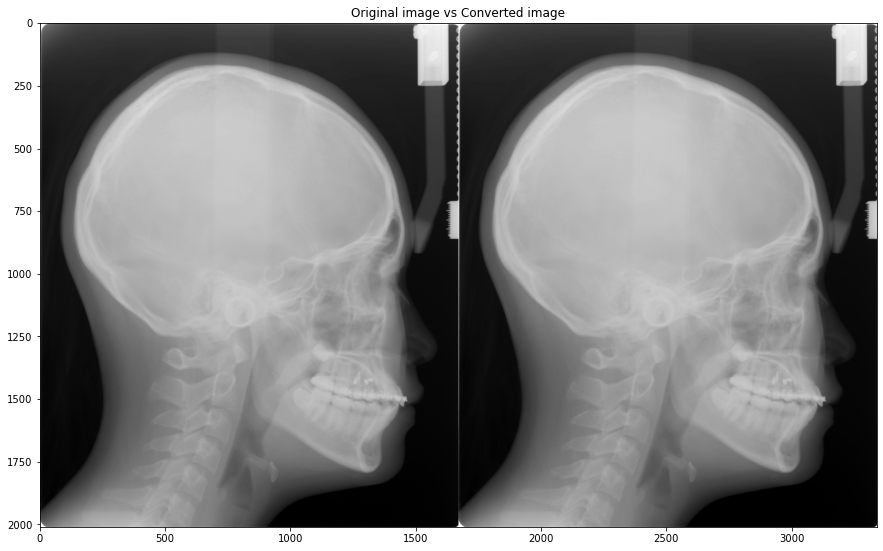

dcm path:  1.2.392.200036.9125.4.0.4279151202.2377911552.3461784593-1636809805181.dcm
tag:  {'RescaleSlope': '2.81525', 'RescaleIntercept': '-240.0', 'VOILUTFunction': 'None', 'WindowCenter': 'None', 'WindowWidth': 'None', 'PhotometricInterpretation': 'MONOCHROME1'}
Original | shape: (2010, 1670), min: 0, max: 255, std: 71.7794763728903, var: 5152.293228366318
Converted | shape: (2010, 1670), min: 0, max: 255, std: 71.77901694848167, var: 5152.227274090418


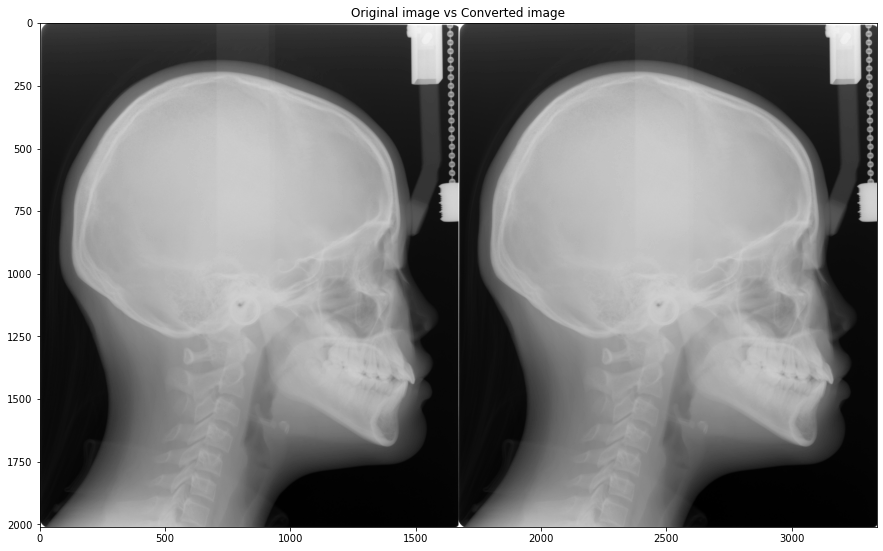

dcm path:  1.3.6.1.4.1.25403.114374077469065.896.20181110115936.152-1636809274674.dcm
tag:  {'RescaleSlope': '1.0', 'RescaleIntercept': '0.0', 'VOILUTFunction': 'None', 'WindowCenter': '2200.0', 'WindowWidth': '5000.0', 'PhotometricInterpretation': 'MONOCHROME2'}
Original | shape: (2238, 1956), min: 9, max: 255, std: 62.97468773823954, var: 3965.8112957287776
Converted | shape: (2238, 1956), min: 0, max: 255, std: 66.98229142458626, var: 4486.627364488202


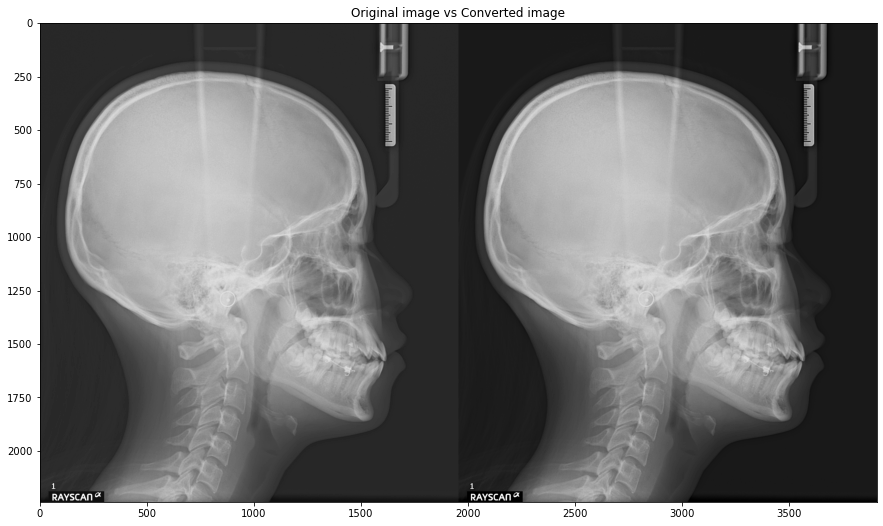

dcm path:  1.3.6.1.4.1.25403.114374077469065.968.20190311151732.368-1636818675720.dcm
tag:  {'RescaleSlope': '1.0', 'RescaleIntercept': '0.0', 'VOILUTFunction': 'None', 'WindowCenter': '2200.0', 'WindowWidth': '5000.0', 'PhotometricInterpretation': 'MONOCHROME2'}
Original | shape: (2238, 1956), min: 9, max: 255, std: 61.17957248496964, var: 3742.9400894436544
Converted | shape: (2238, 1956), min: 0, max: 255, std: 65.05599319172237, var: 4232.282250161426


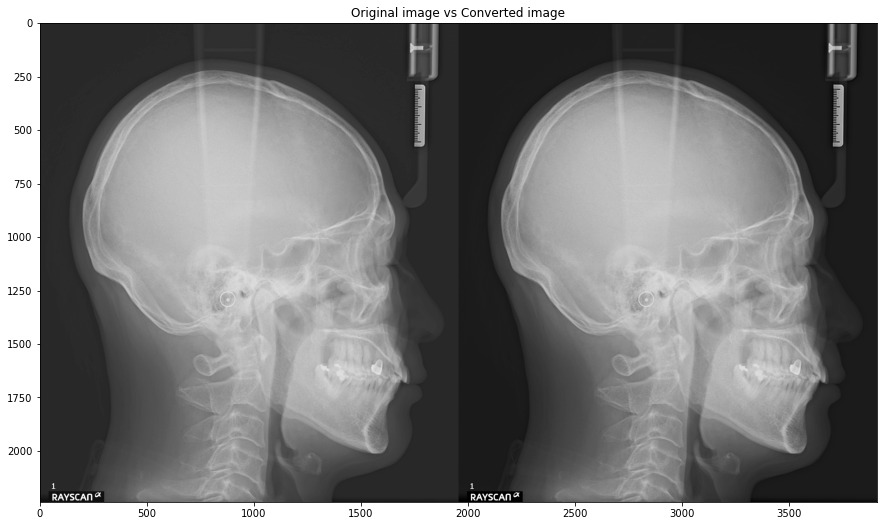

dcm path:  2.16.840.1.113669.632.10.20201218.160720078.472581.370-1636958109969.dcm
tag:  {'RescaleSlope': '1.0', 'RescaleIntercept': '0.0', 'VOILUTFunction': 'None', 'WindowCenter': '2047.0', 'WindowWidth': '4095.0', 'PhotometricInterpretation': 'MONOCHROME2'}
Original | shape: (1938, 2092), min: 0, max: 255, std: 52.71495121197064, var: 2778.866081280445
Converted | shape: (1938, 2092), min: 0, max: 255, std: 52.704216931505854, var: 2777.7344823632284


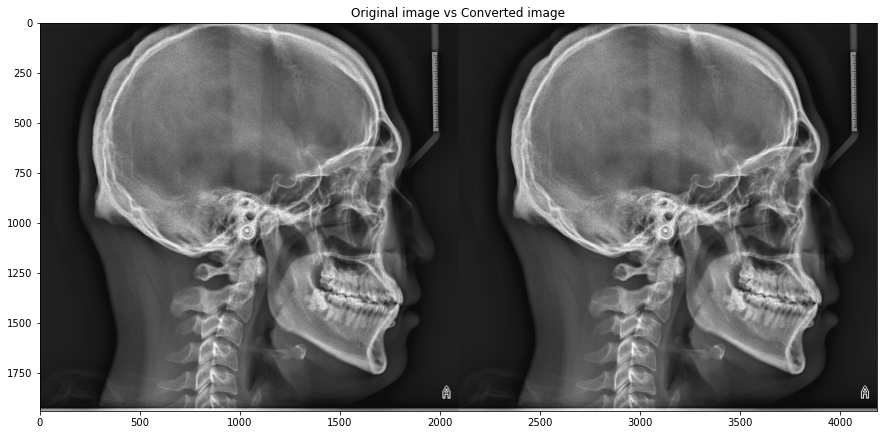

In [20]:
# 정리
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from func import dcm2img

dcm_lst = glob('./data/*.dcm')
for idx in range(len(dcm_lst)):
    dcm_path = dcm_lst[idx]
    img_path = os.path.join(dcm_path.split('\\')[0], dcm_path.split('\\')[-1][:-3] + 'jpeg')

    org_img = cv2.imread(img_path, 0)
    image = dcm2img(dcm_path)
    res = np.hstack((org_img, image))

    print("dcm path: ", dcm_path.split('\\')[-1])
    tag = getTag(dcm_path)
    print("tag: ", tag)
    print(f"Original | shape: {org_img.shape}, min: {org_img.min()}, max: {org_img.max()}, std: {org_img.std()}, var: {org_img.var()}")
    print(f"Converted | shape: {image.shape}, min: {image.min()}, max: {image.max()}, std: {image.std()}, var: {image.var()}")


    plt.figure(figsize=(15, 15))
    plt.title('Original image vs Converted image')
    plt.imshow(res, 'gray')
    plt.show() 